In [ ]:
#



In [2]:
# Imports

import numpy as np
import os
from PIL import Image, ImageColor, ImageDraw, ImageFont
from typing import Any, Dict, List

from upper_bounds import (
    # SolutionNumbers,
    # SolutionUpperBounds,
    # NumberedSolutionUpperBounds,
    get_solution_numbers,
    get_solution_upper_bounds,    
    get_numbered_solution_upper_bounds,
)
from util import (
    convert_pil_image_to_bytes,
    load_image_from_file,
)


In [13]:
# Prompt

def upper_bounds_system_prompt() -> str:
    system_prompt = f"""
    Return the y-axis positions for the upper bound of the problems in the image corresponding to the provided problem numbers, normalized by 1000.
    """
    return system_prompt
    # system_prompt = f"""
    # Return the y-axis positions at which the provided problem identifiers or labels begin in the provided image.
    # """
    # return system_prompt


def upper_bounds_user_prompt(solution_numbers: List[str]) -> str:

    user_prompt=f"""
    Detect the y-coordinate of the upper boundary problems in the provided image, including the problem statement.

    TASK DEFINITION:
    - For each problem identifier provided in the input list, identify the upper boundary of the entire problem, including the problem statement.
    - Return the y-coordinate value (in pixels from the top of the image) for this upper boundary.
    - The y-coordinate represents the vertical position where the identifier to a problem begins.

    PROBLEM NUMBERING CONVENTIONS:
    - Problem identifiers are provided as strings in the solution_numbers list.
    - These identifiers represent main problems (e.g., "1", "2.", "3)", "4.5")

    OUTPUT FORMAT:
    - Use -1 for any problem whose boundary cannot be confidently determined, or if the problem is not present in the image.

    HANDLING EDGE CASES:
    - If problem boundaries are unclear or solutions overlap, use visual cues such as whitespace, horizontal lines, or changes in formatting to determine boundaries.
    - If multiple possible boundaries exist, choose the most visually distinct one.

    The problem identifiers to detect are: {solution_numbers}
    """
    return user_prompt

    # user_prompt=f"""
    # Detect the y-coordinate of the problem identifiers in the provided image.

    # TASK DEFINITION:
    # - For each problem identifier provided identify the upper boundary of the identifier.
    # - Return the y-coordinate value (in pixels from the top of the image) for this upper boundary.
    # - The y-coordinate represents the vertical position of the top of the identifier.

    # PROBLEM NUMBERING CONVENTIONS:
    # - Problem identifiers are provided as strings in the solution_numbers list.
    # - These identifiers represent problems in a homework assignment or in an exam
    # - Identifiers are typically on the leftside, near or at the top of a problem
    # - Identifiers may be followed by a period, a parenthesis, or other notation (e.g., "1.", "2)", "3)", "4.5)")
    # - Identifiers may be multiple numbers separated by a period (e.g., "1.2", "2.3.4")

    # OUTPUT FORMAT:
    # - Use -1 for any identifier whose boundary cannot be confidently determined, or if the idientifer is not present in the image.

    # HANDLING EDGE CASES:
    # - If problem identifier boundaries are unclear or solutions overlap, use visual cues such as whitespace, horizontal lines, or changes in formatting to determine boundaries.
    # - If multiple possible boundaries exist, choose the most visually distinct one.

    # The problem identifiers to detect are: {solution_numbers}
    # """
    # return user_prompt



In [16]:
# Define the input directory and image height

INPUT_DIRECTORY = "jpg"
IMAGE_HEIGHT = str(640)

In [17]:
#

class Assignment():

    def __init__(self, assignment_name: str, input_directory: str, problem_numbers: List[str]):
        self.assignment_name: str = assignment_name
        self.input_directory: str = input_directory
        self.problem_numbers: List[str] = problem_numbers
        self.pages: List[Page] = []

        self.image_height = IMAGE_HEIGHT

        self._add_pages()

        print(f"Created assignment {self.assignment_name} with {len(self.pages)} pages.")
        print(f"Problem numbers: {self.problem_numbers}")
        print(f"Pages: {[page.page_name for page in self.pages]}")


    def _add_pages(self) -> None:

        # Get sorted list of jpgs matching the assignment name and image height (see __init__)
        page_jpgs = [page_jpg for page_jpg in sorted(os.listdir(self.input_directory)) if self.assignment_name in page_jpg and self.image_height in page_jpg]

        self.pages = []
        for page_jpg in page_jpgs:
            page = Page(page_name=page_jpg.split(".jpg")[0], input_directory=self.input_directory, input_file=page_jpg)
            self.pages.append(page)

    

    async def find_problem_positions(self):

        for page in self.pages:
            response = await get_numbered_solution_upper_bounds(
                    image_bytes=page.image_bytes,
                    system_prompt=upper_bounds_system_prompt(),
                    user_prompt=upper_bounds_user_prompt(self.problem_numbers),
                    solution_numbers=self.problem_numbers,
                )
            page.response = response
            for k2 in range(0, len(self.problem_numbers)):
                if response.structured_response.upper_bounds[k2].upper_bound != -1:
                    page.found_problems_normalized[self.problem_numbers[k2]] = response.structured_response.upper_bounds[k2].upper_bound
                    page.found_problems[self.problem_numbers[k2]] = int(np.floor(page.pil_image.size[1] / 1000 * response.structured_response.upper_bounds[k2].upper_bound))
        

class Page():

    def __init__(self, page_name: str, input_directory: str, input_file: str):
        self.page_name = page_name
        self.input_directory = input_directory
        self.input_file = input_file
        self.path_to_input_file = str(os.path.join(self.input_directory, self.input_file))
        self.pil_image = load_image_from_file(file_path = self.path_to_input_file)
        self.image_bytes = convert_pil_image_to_bytes(pil_image=self.pil_image, format="JPEG", quality=100)
        self.response = None
        self.found_problems = {}
        self.found_problems_normalized = {}
        


In [18]:
# Define the assignment name and problems

assignment_name = "E_231_HW_02"
assignment_problems = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]

assignment_name = "E_231_HW_03"
assignment_problems = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]

# assignment_name = "E_231_HW_04"
# assignment_problems = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]

# assignment_name = "E_231_HW_05"
# assignment_problems = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]

# assignment_name = "E_231_HW_06"
# assignment_problems = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]

# assignment_name = "IEOR_262B_HW_01"
# assignment_problems = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]

# assignment_name = "IEOR_262B_HW_02"
# assignment_problems = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]

# assignment_name = "IEOR_262B_HW_02"
# assignment_problems = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]

# assignment_name = "MAE_101B_HW_01"
# assignment_problems = ["1", "2", "3"]

# assignment_name = "MAE_101B_HW_02"
# assignment_problems = ["1", "2", "3", "4"]

# assignment_name = "MAE_101B_HW_03"
# assignment_problems = ["1", "2", "3", "4"]

# assignment_name = "MAE_101C_HW_01"
# assignment_problems = ["1.6", "1.10", "1.17", "1.28", "2.5", "2.11", "2.27", "2.31", "2.41", "2.52"]

# assignment_name = "MAE_101C_HW_02"
# assignment_problems = ["3.13", "3.46", "3.79", "3.108", "3.118", "3.142", "4.5", "4.16"]

# assignment_name = "MAE_101C_HW_03"
# assignment_problems = ["1", "2", "3", "4"]

# assignment_name = "MAE_104_HW_01"
# assignment_problems = ["1.1", "1.2", "1.4", "1.7", "1.9", "1.10", "1.12", "1.14"]

# assignment_name = "MAE_130C_HW_02"
# assignment_problems = ["2.20", "2.24", "2.47"]

# assignment_name = "MAE_280A_HW_01"
# assignment_problems = ["7", "8", "9"]

# assignment_name = "MAE_280A_HW_03"
# assignment_problems = ["1", "2", "3"]

# assignment_name = "MAE_280A_HW_04"
# assignment_problems = ["2.31", "2.32", "2.33", "2.34", "2.35", "2.36", "2.37", "2.38", "2.39", "2.18"]



In [19]:
# Find problem positions for each page in the assignment

assignment = Assignment(assignment_name=assignment_name, input_directory=INPUT_DIRECTORY, problem_numbers=assignment_problems)
await assignment.find_problem_positions()


Created assignment E_231_HW_03 with 7 pages.
Problem numbers: ['1', '2', '3', '4', '5', '6', '7', '8', '9']
Pages: ['E_231_HW_03_00_640', 'E_231_HW_03_01_640', 'E_231_HW_03_02_640', 'E_231_HW_03_03_640', 'E_231_HW_03_04_640', 'E_231_HW_03_05_640', 'E_231_HW_03_06_640']


In [20]:
# View results

for page in assignment.pages:
    print(f"Page: {page.page_name}")
    print(f"Found problems: {page.found_problems}")
    print(f"Found problems normalized: {page.found_problems_normalized}")
    print()


Page: E_231_HW_03_00_640
Found problems: {'1': 54, '2': 178}
Found problems normalized: {'1': 85, '2': 279}

Page: E_231_HW_03_01_640
Found problems: {'3': 57}
Found problems normalized: {'3': 90}

Page: E_231_HW_03_02_640
Found problems: {}
Found problems normalized: {}

Page: E_231_HW_03_03_640
Found problems: {'4': 53}
Found problems normalized: {'4': 84}

Page: E_231_HW_03_04_640
Found problems: {}
Found problems normalized: {}

Page: E_231_HW_03_05_640
Found problems: {'5': 56}
Found problems normalized: {'5': 88}

Page: E_231_HW_03_06_640
Found problems: {}
Found problems normalized: {}



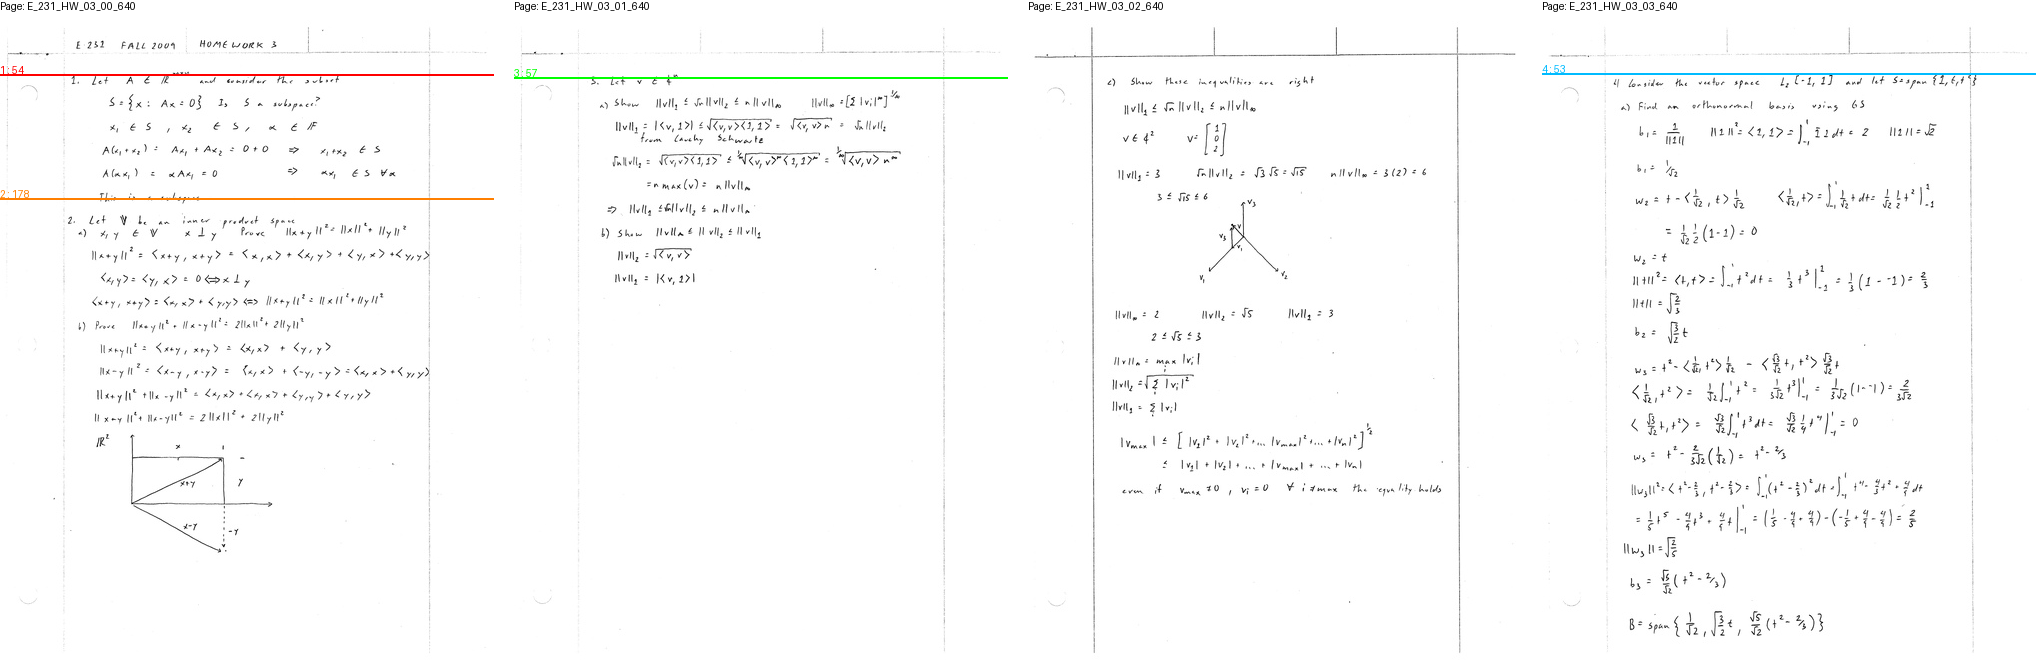

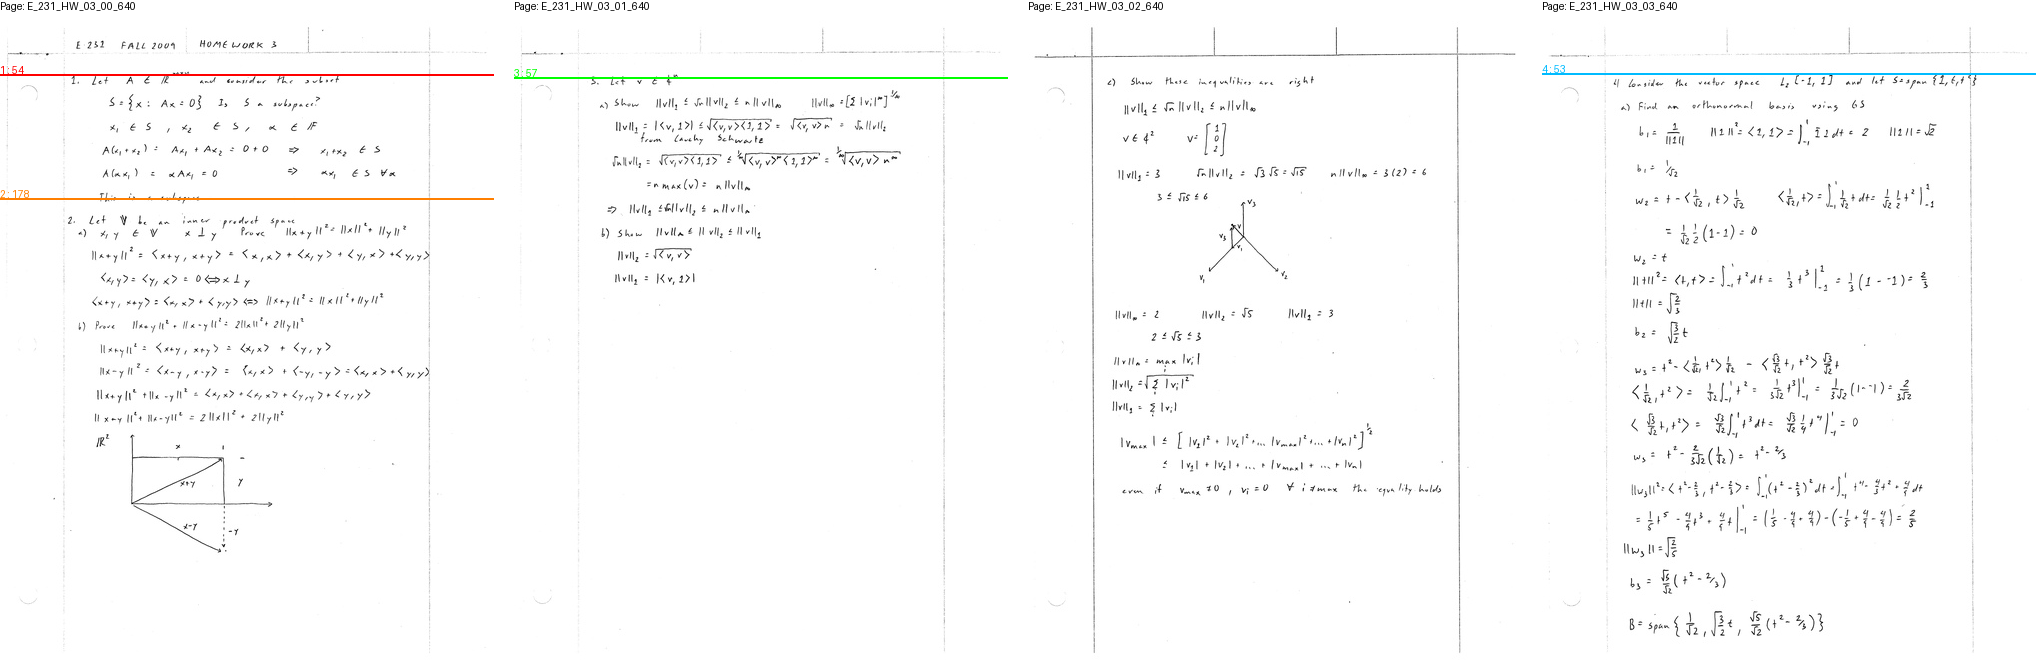

In [31]:
#

custom_colors = [
    "#FF0000",  # Red
    "#FF7F00",  # Orange
    # "#FFFF00",  # Yellow
    "#00FF00",  # Green
    "#00BBFF",  # Cyan
    "#0000FF",  # Blue
    "#4B0082",  # Indigo
    "#9400D3",  # Violet
    # "#FF00FF",  # Magenta
    "#800080",  # Purple
]

def plot_solution_upper_bounds(assignment: Assignment, page_numbers: List[int], create_copy: bool = True) -> Image.Image:
    """
    Plots horizontal lines on an image at specified vertical positions.
    
    Args:
        pil_image: The PIL Image object to draw on
        solution_upper_bounds: A list of vertical positions (y-coordinates) for horizontal lines
        create_copy: If True, creates a copy of the image before drawing. If False, draws on the original.
    
    Returns:
        The image with drawn lines (either a copy or the original)
    """


    if page_numbers == []:
        pages = assignment.pages
    else:
        pages = [assignment.pages[page_number] for page_number in page_numbers]

    total_width = 0
    max_height = 0
    for page in pages:
        total_width += page.pil_image.size[0]
        max_height = max(max_height, page.pil_image.size[1])

    stacked_pages = Image.new("RGB", (total_width + 20*(len(pages)-1), max_height+20), (255, 255, 255))

    # draw = ImageDraw.Draw(stacked_pages)

    for k1, page in enumerate(pages):

        page_image = page.pil_image.copy().convert("RGB")
        draw = ImageDraw.Draw(page_image)

        for k2, problem_number in enumerate(list(page.found_problems.keys())):

            x1 = 0
            x2 = page_image.width
            y1 = int(page.found_problems[problem_number])

            color_index = assignment.problem_numbers.index(problem_number) % len(custom_colors)

            # Draw the horizontal line
            draw.line((x1, y1, x2, y1), fill=custom_colors[color_index], width=2)
            draw.text((x1, y1-10), f"{problem_number} : {y1}", fill=custom_colors[color_index])

        draw = ImageDraw.Draw(stacked_pages)
        draw.text((k1*(page_image.width+20), 0), f"Page: {page.page_name}", fill=(0, 0, 0))
        stacked_pages.paste(page_image, (k1*(page_image.width+20), 20))

    display(stacked_pages)
    return stacked_pages

plot_solution_upper_bounds(assignment=assignment, page_numbers=[0, 1, 2, 3])


In [32]:
# Limitations

# LLM somteimes does not find all the problems

# LLM sometimes does not find multi-part problems, such as 2.34, 1.8 etc

# LLM sometimes includes portions of the previous solution  when defining boundaries
# -- Will the grading AI detect this, and maybe elimiate?
# -- Maybe we pad the problem boundaries, clip the images, and do a second round of boundary detection?

# LLM sometimes confuses the solution with problem boundary
# -- E_231_HW_05, LLM confuses matrices with indexed 1, 2, 3, ... as problem boundaries for problems 1, 2, 3
# -- LLM still finds proper problem boundaries in this case, including the problem in which the matrices are located
# -- Possibly fixed with combination of specific marking and prompt engineering

# LLM can confuse 3 and 5, if they look alike (my handwriting)
# LLM can confuse 6 and b, if they look alike (my handwriting)

# LLM finds problems with ) after number, but missed the problem without ) after number
# -- IEOR_262B_HW_01, LLM finds 1), 2), 3), 4), but not 5
# -- prompting issue?

# LLM will struggle if parts of solutions contain very similar markings to problem labels
# -- IEOR_262B_HW_02, problem 1) has steps 1) and 2) denoting necessary conditions, which LLM confuses with problem labels

# What to do if problems are out of order in papers?
# Assume pages are in order, at least for each problem, if problems span more than one page


Current Page: E_231_HW_03_00_640
-- Sorted problems on current page: [('1', 54), ('2', 178)]
Multiple problems on page
---- Problem 1 - Position: 54


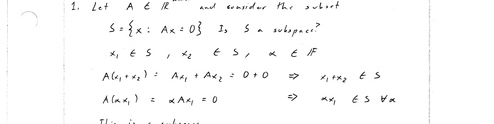

---- Problem 2 - Position: 178


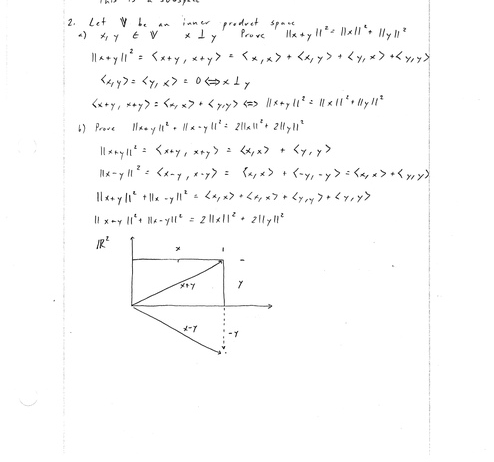

---- Problems on next page: [('3', 57)]
---- Problem(s)s on next page


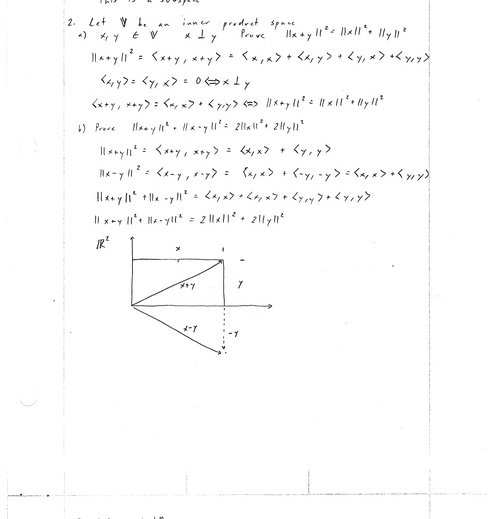


Current Page: E_231_HW_03_01_640
-- Sorted problems on current page: [('3', 57)]
-- One problem on page
---- Problem 3 - Position: 57


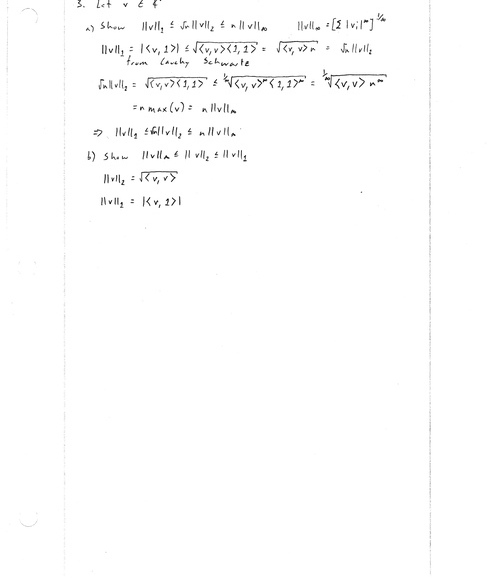

---- Problems on next page: []
---- No problems on next page


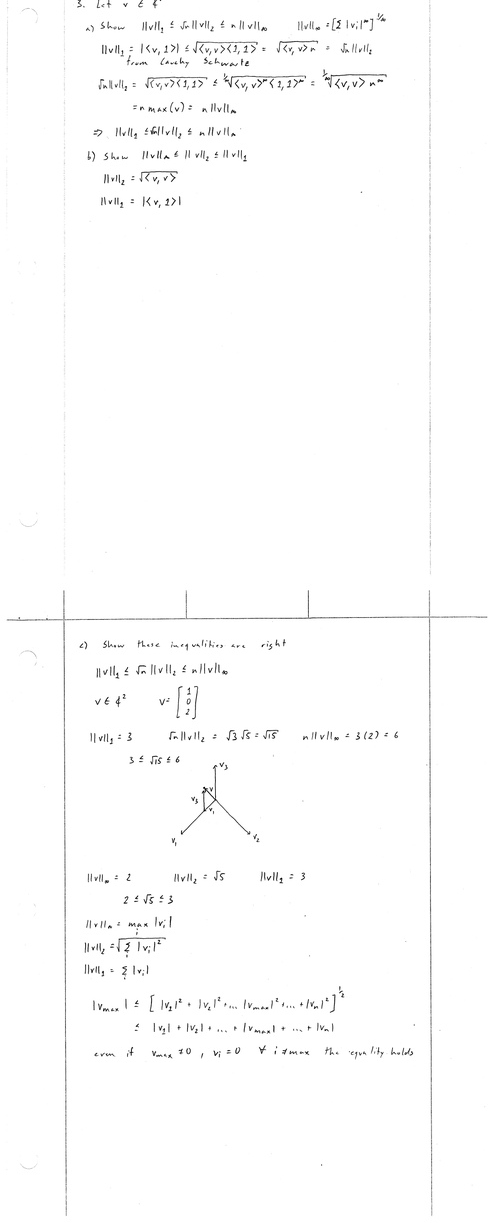

---- Problems on next page: [('4', 53)]
---- Problem(s)s on next page


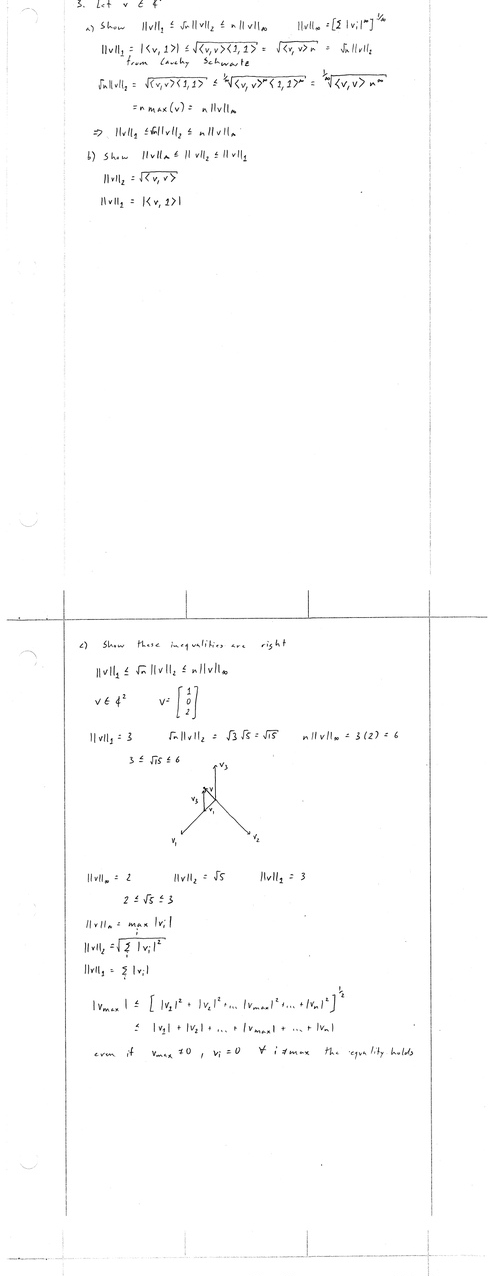


Current Page: E_231_HW_03_02_640
-- Sorted problems on current page: []
-- No problems on page

Current Page: E_231_HW_03_03_640
-- Sorted problems on current page: [('4', 53)]
-- One problem on page
---- Problem 4 - Position: 53


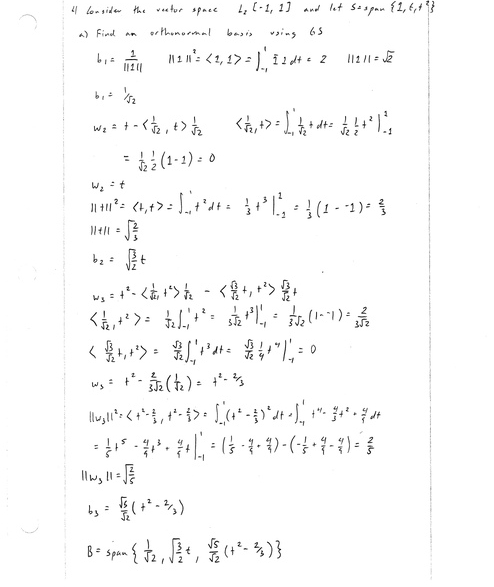

---- Problems on next page: []
---- No problems on next page


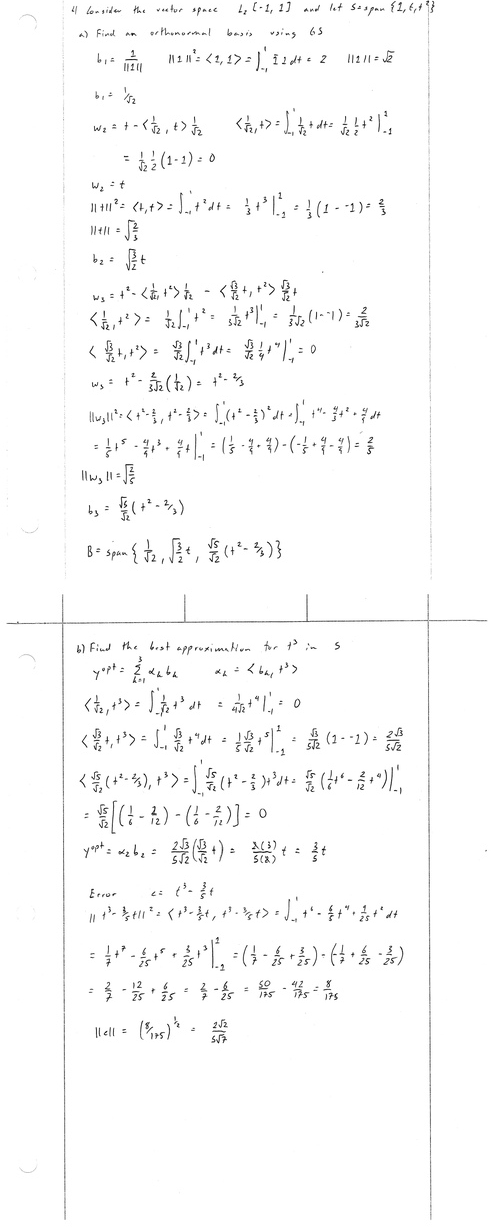

---- Problems on next page: [('5', 56)]
---- Problem(s)s on next page


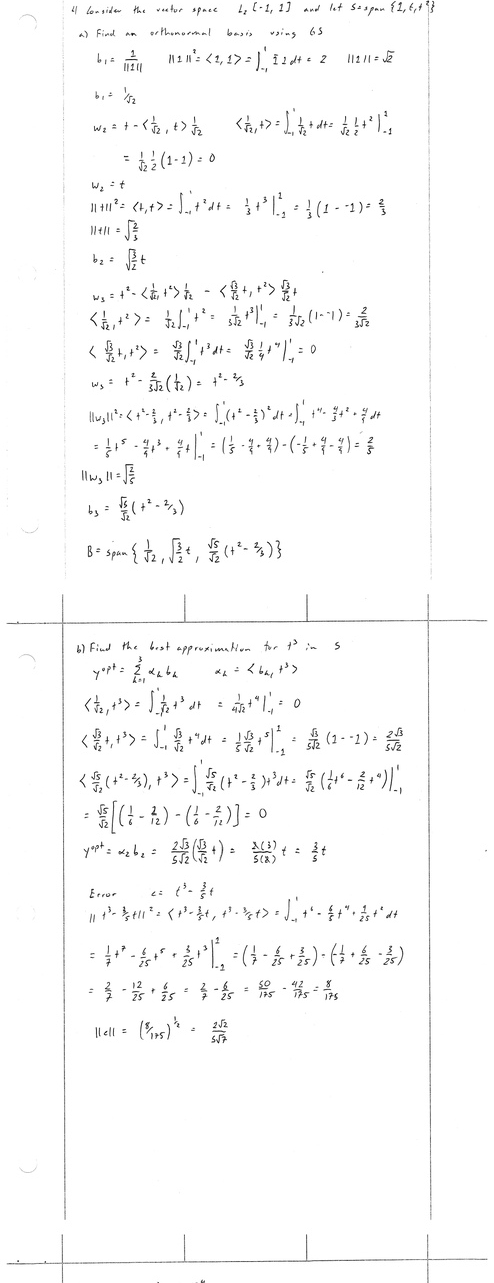


Current Page: E_231_HW_03_04_640
-- Sorted problems on current page: []
-- No problems on page

Current Page: E_231_HW_03_05_640
-- Sorted problems on current page: [('5', 56)]
-- One problem on page
---- Problem 5 - Position: 56


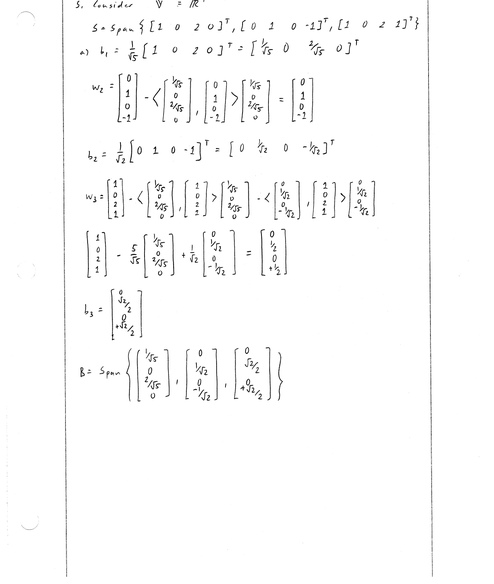

---- Problems on next page: []
---- No problems on next page


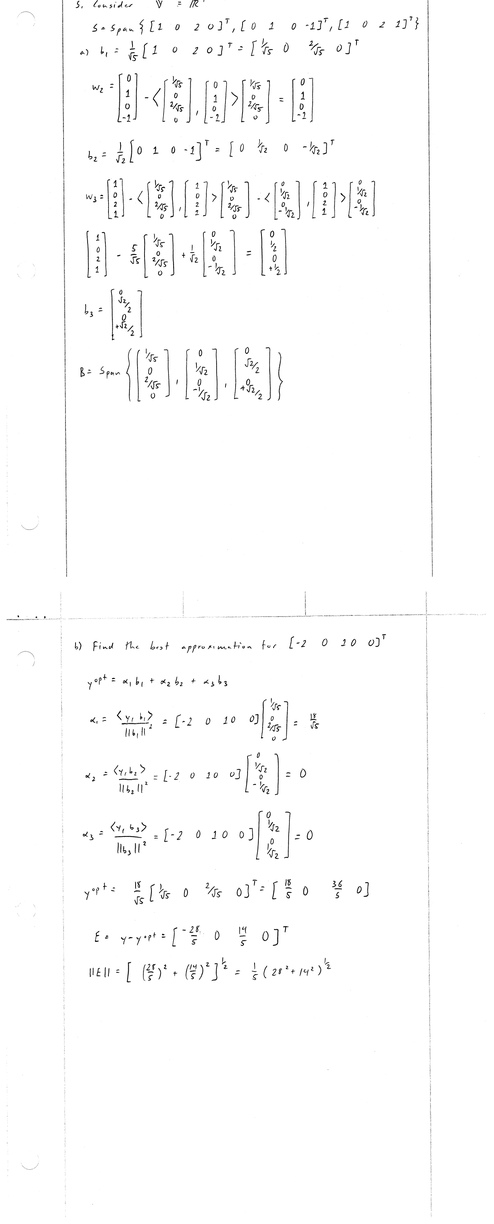


Current Page: E_231_HW_03_06_640
-- Sorted problems on current page: []
-- No problems on page


In [ ]:
#

from ast import Tuple
import numpy as np

# pages["MAE_280A_HW_04_07_640"].upper_bounds = {"2.37": 60/1000*640}


def get_sorted_problems_on_page(page: Page) -> List[Tuple]:

    return sorted(page.found_problems.items(), key=lambda x: np.floor(x[1]))


def separate_problems(assignment: Assignment) -> List[Image.Image]:
    """
    Separate problems in the image based on the upper bounds.
    
    Args:
        upper_bounds_cases: A list of UpperBoundsCase objects containing the image and upper bounds.
    
    Returns:
        A list of images, each containing a separate problem.
    """
    
    # Create a list to store the separated problem images
    separated_images = {}

    page_names = [page.page_name for page in assignment.pages]
    pages = assignment.pages

    for k1, page in enumerate(pages):

        print(f"\nCurrent Page: {page.page_name}")

        sorted_problems_current_page = get_sorted_problems_on_page(page=page)
        print(f"-- Sorted problems on current page: {sorted_problems_current_page}")

        if len(sorted_problems_current_page) == 0:
            print("-- No problems on page")
        elif len(sorted_problems_current_page) == 1:
            print("-- One problem on page")

            current_problem_number = sorted_problems_current_page[0][0]
            print(f"---- Problem {current_problem_number} - Position: {sorted_problems_current_page[0][1]}")

            current_image = page.pil_image.copy()
            current_image = current_image.crop((0, sorted_problems_current_page[0][1], current_image.size[0], current_image.size[1]))
            display(current_image)
            separated_images[current_problem_number] = current_image

        elif len(sorted_problems_current_page) > 1:
            print("Multiple problems on page")

            for k2, sorted_problem in enumerate(sorted_problems_current_page):
                print(f"---- Problem {sorted_problem[0]} - Position: {sorted_problem[1]}")

                current_problem_number = sorted_problems_current_page[k2][0]

                if k2 < len(sorted_problems_current_page) - 1:
                    current_image = page.pil_image.copy()
                    current_image = current_image.crop((0, sorted_problems_current_page[k2][1], current_image.size[0], sorted_problems_current_page[k2+1][1]))
                elif k2 == len(sorted_problems_current_page) - 1:
                    current_image = page.pil_image.copy()
                    current_image = current_image.crop((0, sorted_problems_current_page[k2][1], current_image.size[0], current_image.size[1]))
                display(current_image)
                separated_images[current_problem_number] = current_image

        # Continue searching through next page(s) to find areas to stitch togehter
        if len(sorted_problems_current_page) >= 1:
            # Continuing from last page
            k3 = k1 + 1
            while k3 < len(pages):
                next_page = pages[k3]
                sorted_problems_next_page = get_sorted_problems_on_page(page=next_page)
                print(f"---- Problems on next page: {sorted_problems_next_page}")
                if len(sorted_problems_next_page) == 0:
                    print("---- No problems on next page")

                    next_page_image = next_page.pil_image.copy()
                    # next_page_image = next_page_image.crop((0, 0, next_page_image.size[0], sorted_problem_postions[0][1]))

                    # Create new image with combined height
                    total_height = current_image.height + next_page_image.height
                    max_width = max(current_image.width, next_page_image.width)

                    stacked_image = Image.new("L", (max_width, total_height))

                    stacked_image.paste(current_image, (0, 0))
                    stacked_image.paste(next_page_image, (0, current_image.height))

                    current_image = stacked_image

                    display(current_image)
                    
                elif len(sorted_problems_next_page) >= 1:
                    
                    print("---- Problem(s)s on next page")
                    next_page_image = next_page.pil_image.copy()
                    next_page_image = next_page_image.crop((0, 0, next_page_image.size[0], sorted_problems_next_page[0][1]))

                    total_height = current_image.height + next_page_image.height
                    max_width = max(current_image.width, next_page_image.width)

                    stacked_image = Image.new("L", (max_width, total_height))

                    stacked_image.paste(current_image, (0, 0))
                    stacked_image.paste(next_page_image, (0, current_image.height))

                    current_image = stacked_image

                    display(current_image)

                    break

                k3 += 1
            separated_images[current_problem_number] = current_image

    return separated_images

# X = separate_problems(pages=pages, problem_numbers=pages["MAE_280A_HW_04_00_640"].solution_numbers)
separated_problems = separate_problems(assignment=assignment)


In [ ]:


for problem in separated_problems.keys():
    print(f"Problem: {problem} - Size: {separated_problems[problem].size}")
    display(separated_problems[problem])
    # separated_problems[problem].save(os.path.join("separated", f"{problem}.jpg"), "JPEG", quality=100)